In [5]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt

In [6]:
tensorTimeSeries = torch.load("time_series.pt")
tensorMasks = torch.load("masks.pt")
tensorDiffs = torch.load("diffs.pt")

# turn into numpy arrays

npTimeSeries = tensorTimeSeries.numpy()
npMasks = tensorMasks.numpy()
npDiffs = tensorDiffs.numpy()

print(len(npTimeSeries)) # number of patients: 6261
print(len(npTimeSeries[0])) # columnlength: 192
print(len(npTimeSeries[0][0])) # rowlength: 52

print("Row Length: ", len(npTimeSeries[0][0]))
print("Column Length: ", len(npTimeSeries[0][:,0]))
print("time series", npTimeSeries, "\n")
print("masks", npMasks, "\n")
print("diffs", npDiffs, "\n")



6261
192
59
Row Length:  59
Column Length:  192
time series [[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.4145498  0.07772809 0.2590936 ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.44404888 0.08325917 0.27753055]]

 [[0.         0.         0.         

In [7]:
# Ladies and gents, this is LOCF (Last observation carried forward), SIMPLE EXAMPLE ... 

smallTS = np.array([[0, 0, 5],
    [3, 4, 0],
     [0, 0, 0],
    [7, 2, 0],
    [0, 0, 2],
    [2, 1, 0],
    [0, 0, 0]])

smallMasks = np.array([[1, 1, 0],
        [0, 0, 1],
        [1, 1, 1],
        [0, 0, 1],
        [1, 1, 0],
        [0, 0, 1],
        [1, 1, 1]])

smallDiffs = np.array([[0, 0, 0],
                 [.02, .02, 0],
                 [0, 0, .02],
                 [.02, .02, .04],
                 [0, 0, .06],
                  [.02, .02, 0],
                  [0, 0, .02]])

# removeOutliers works

def removeOutliers(originalTS):
    
    TS = np.array(originalTS)
    cleanTS = []
    for i in range(len(TS[0])): #len(TS[0]) = 3
        
        varColumn = TS[:,i]
        
        mean = np.mean(varColumn)
        sd = np.std(varColumn)
        boundSet = (mean - 2 * sd, mean + 2 * sd)
        resultList = []
        for y in varColumn:
            if y >= boundSet[0] and y <= boundSet[1]:
                resultList.append(y)
            else:
                resultList.append(0)
        
        cleanTS.append(resultList)
    
    newTS = np.transpose(cleanTS)
    
    return newTS

print(len(smallTS))

def simpleLOCF(TSarray, maskArray, diffArray):
    
    # first, remove the outliers from the original time series array
    roTS = removeOutliers(TSarray)
    
    # next, create the "new masking tensor":
    # if there's an outlier in the TS data and it was masked with a "0", 
    # turn the mask position into a "1" to indicate absence
    
    for row in range(len(roTS)):
        for col in range(len(roTS[0])):
            if TSarray[row][col] - roTS[row][col] >= 1 and maskArray[row][col] == 0:
                maskArray[row][col] = 1
                
    
    # this is where we modify the diffs
    # if mask = 0 (observed), diff = 0
    
    for col in range(len(maskArray[0])): # 3
        for row in range(len(maskArray)): # 7
            if(row==0):
                diffArray[row][col] = 0
            elif maskArray[row][col] == 0:
                diffArray[row][col] = 0
            else:
                diffArray[row][col] = diffArray[row-1][col] + 1/48 
            
    # Now, we actually do LOCF
    # It works :)
    
    rowLength = len(roTS[0]) # len: 3
    columnLength = len(roTS) # len: 7
    
    for col in range(rowLength): # 3
        for row in range(columnLength): # 7
            
            # if the variable is the first row and is missing, keep looking one row ahead until
            # you have found first non-missing value
            if (row==0) and maskArray[row][col] == 1:
                subIndex = 1
                while subIndex < columnLength:
                    if maskArray[subIndex][col] == 0:
                        roTS[row][col] = roTS[subIndex][col]
                        break
                    subIndex +=1

            # else, if the missing variable is anywhere else in the list
            elif(maskArray[row][col] == 1):
                roTS[row][col] = roTS[row-1][col]
            
    return roTS, maskArray, diffArray
       
print(simpleLOCF(smallTS, smallMasks, smallDiffs))


7
(array([[3, 2, 2],
       [3, 2, 2],
       [3, 2, 2],
       [3, 2, 2],
       [3, 2, 2],
       [2, 1, 2],
       [2, 1, 2]]), array([[1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 0, 1],
       [1, 1, 0],
       [0, 0, 1],
       [1, 1, 1]]), array([[0.        , 0.        , 0.        ],
       [0.        , 0.02083333, 0.02083333],
       [0.02083333, 0.04166667, 0.04166667],
       [0.04166667, 0.        , 0.0625    ],
       [0.0625    , 0.02083333, 0.        ],
       [0.        , 0.        , 0.02083333],
       [0.02083333, 0.02083333, 0.04166667]]))


2
(192,)
Patient number 0 Medical variable  0


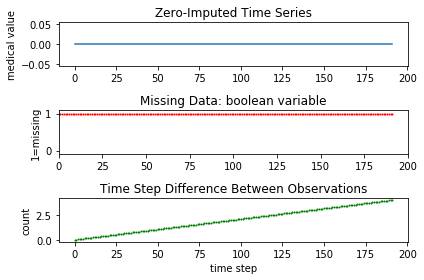

(192,)
Patient number 0 Medical variable  1


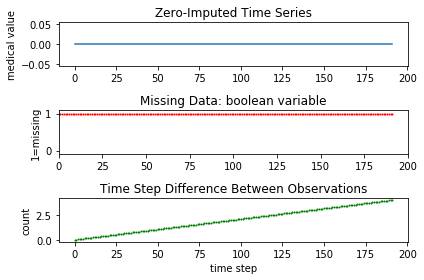

(192,)
Patient number 0 Medical variable  2


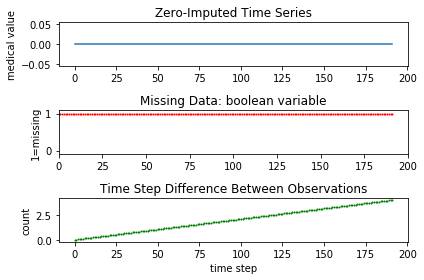

(192,)
Patient number 0 Medical variable  3


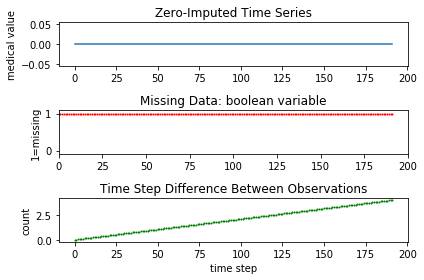

(192,)
Patient number 0 Medical variable  4


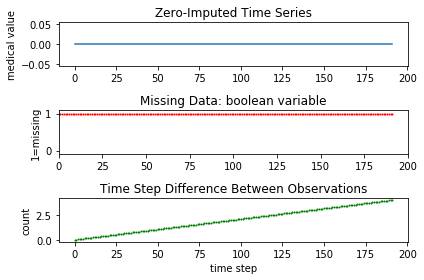

(192,)
Patient number 0 Medical variable  5


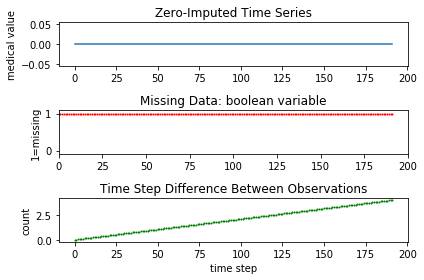

(192,)
Patient number 0 Medical variable  6


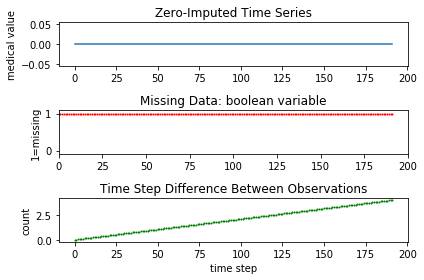

(192,)
Patient number 0 Medical variable  7


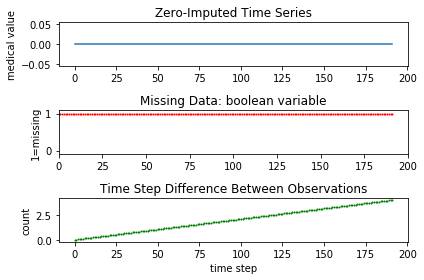

(192,)
Patient number 0 Medical variable  8


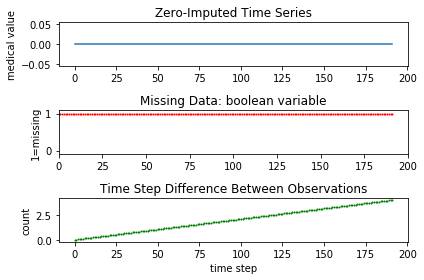

(192,)
Patient number 0 Medical variable  9


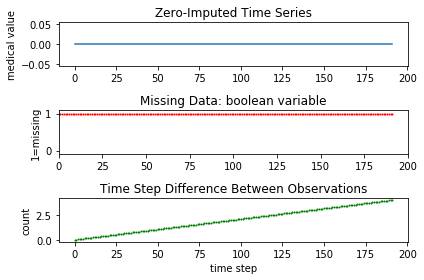

(192,)
Patient number 0 Medical variable  10


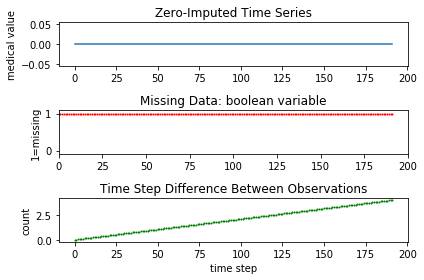

(192,)
Patient number 0 Medical variable  11


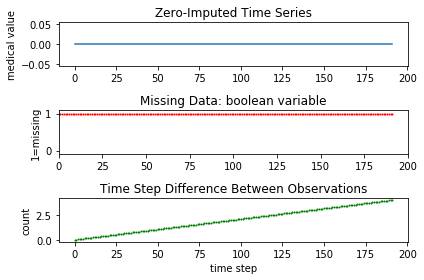

(192,)
Patient number 0 Medical variable  12


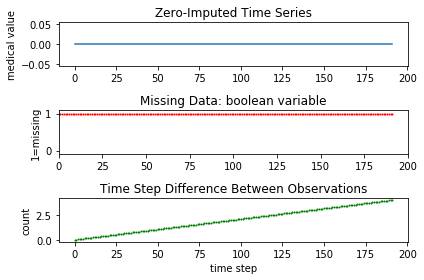

(192,)
Patient number 0 Medical variable  13


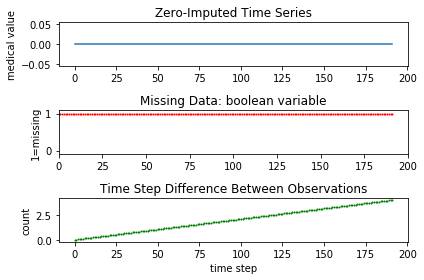

(192,)
Patient number 0 Medical variable  14


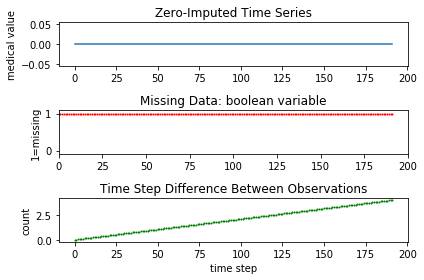

(192,)
Patient number 0 Medical variable  15


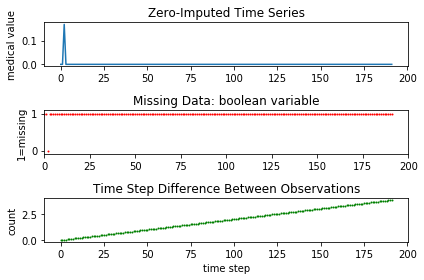

(192,)
Patient number 0 Medical variable  16


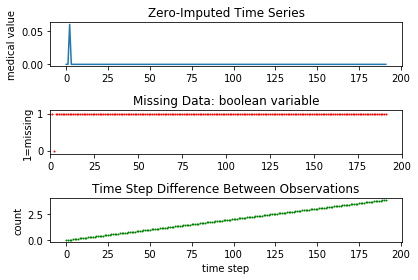

(192,)
Patient number 0 Medical variable  17


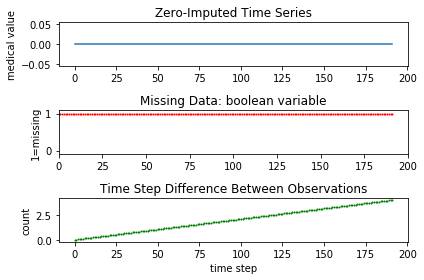

(192,)
Patient number 0 Medical variable  18


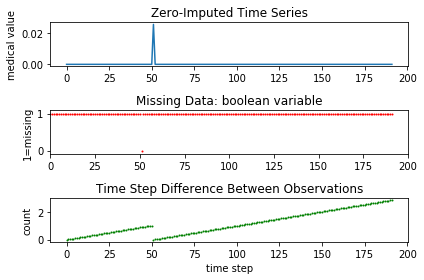

(192,)
Patient number 0 Medical variable  19


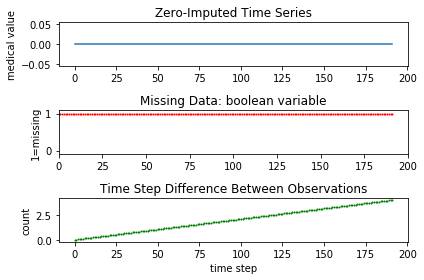

(192,)
Patient number 0 Medical variable  20


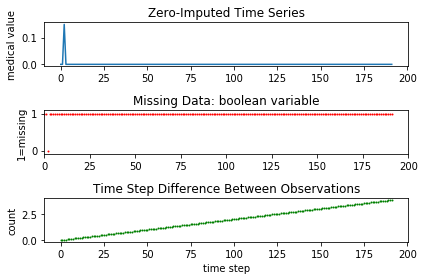

(192,)
Patient number 0 Medical variable  21


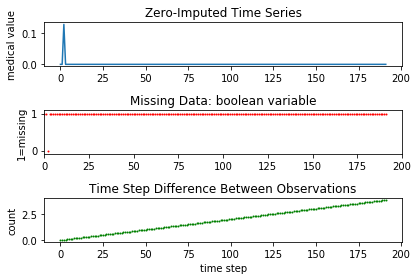

(192,)
Patient number 0 Medical variable  22


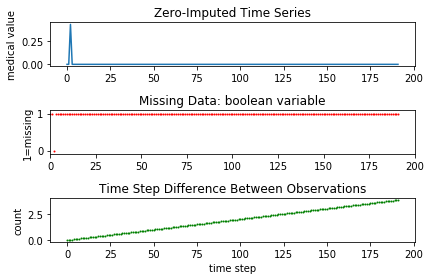

(192,)
Patient number 0 Medical variable  23


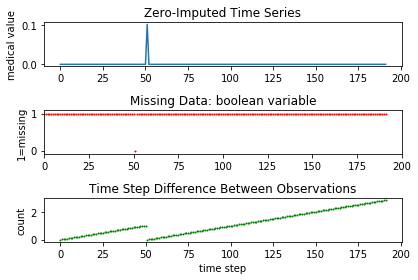

(192,)
Patient number 0 Medical variable  24


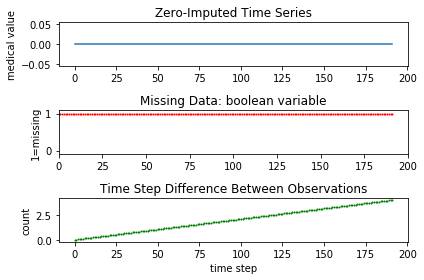

(192,)
Patient number 0 Medical variable  25


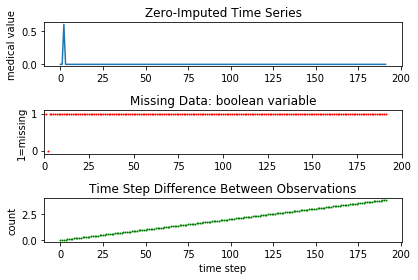

(192,)
Patient number 0 Medical variable  26


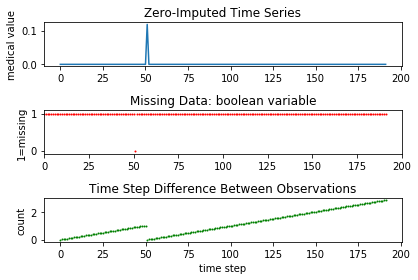

(192,)
Patient number 0 Medical variable  27


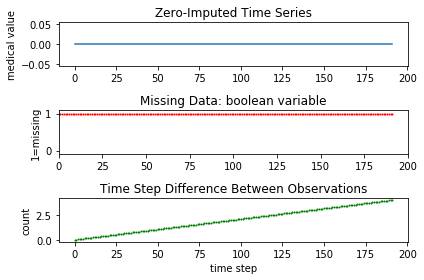

(192,)
Patient number 0 Medical variable  28


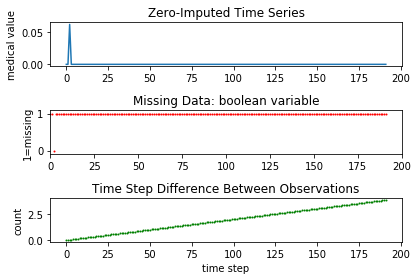

(192,)
Patient number 0 Medical variable  29


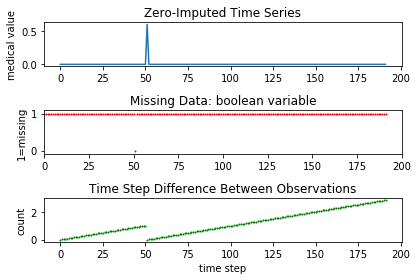

(192,)
Patient number 0 Medical variable  30


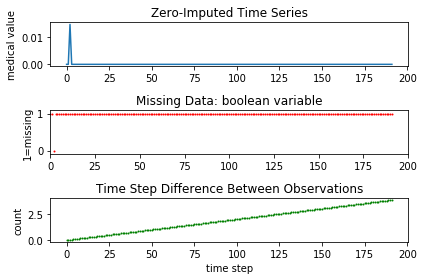

(192,)
Patient number 0 Medical variable  31


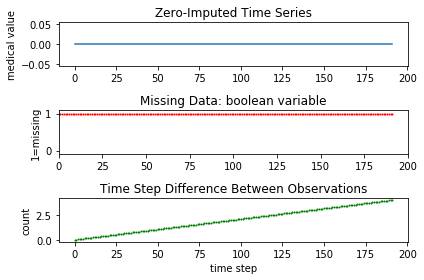

(192,)
Patient number 0 Medical variable  32


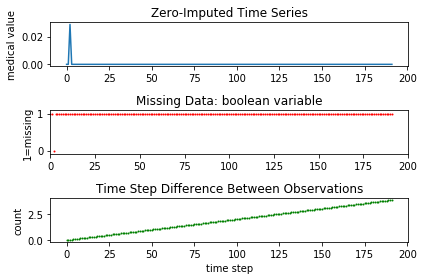

(192,)
Patient number 0 Medical variable  33


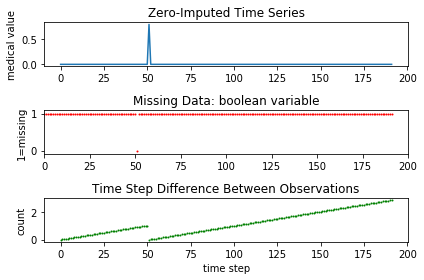

(192,)
Patient number 0 Medical variable  34


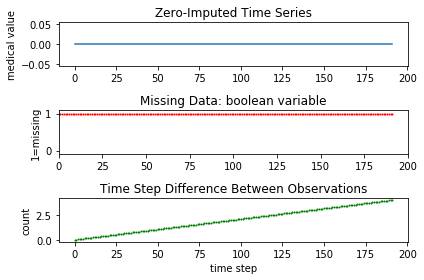

(192,)
Patient number 0 Medical variable  35


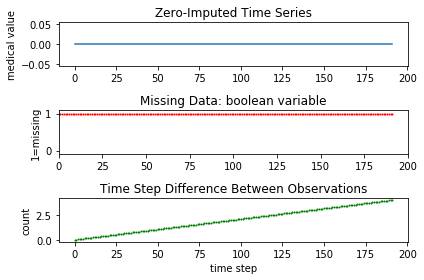

(192,)
Patient number 0 Medical variable  36


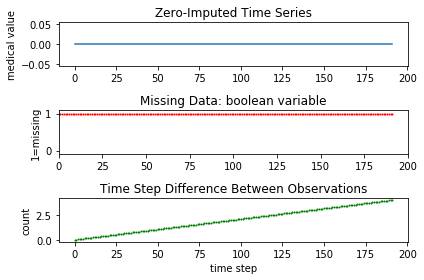

(192,)
Patient number 0 Medical variable  37


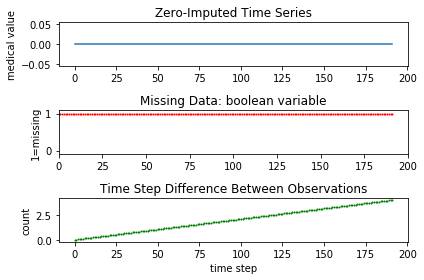

(192,)
Patient number 0 Medical variable  38


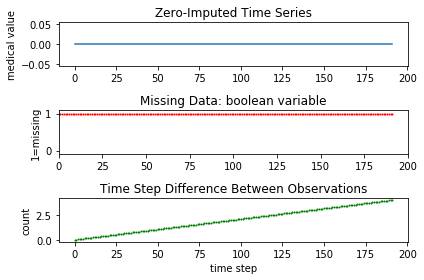

(192,)
Patient number 0 Medical variable  39


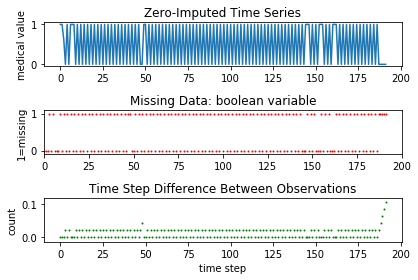

(192,)
Patient number 0 Medical variable  40


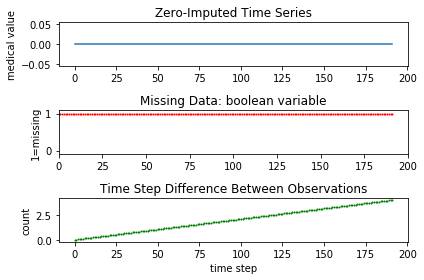

(192,)
Patient number 0 Medical variable  41


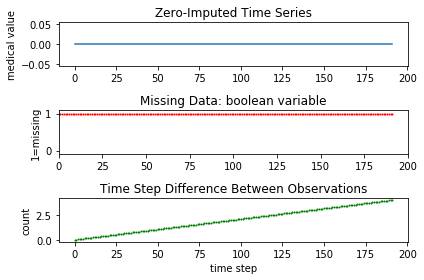

(192,)
Patient number 0 Medical variable  42


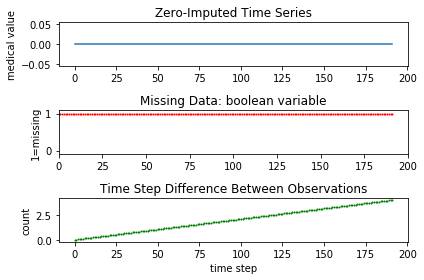

(192,)
Patient number 0 Medical variable  43


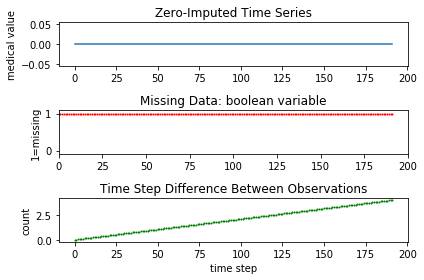

(192,)
Patient number 0 Medical variable  44


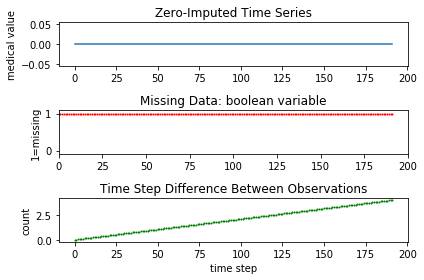

(192,)
Patient number 0 Medical variable  45


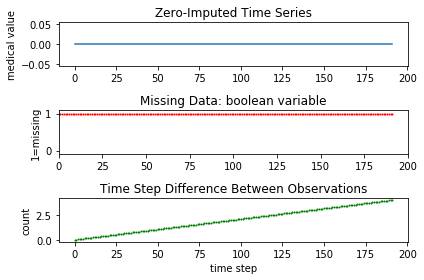

(192,)
Patient number 0 Medical variable  46


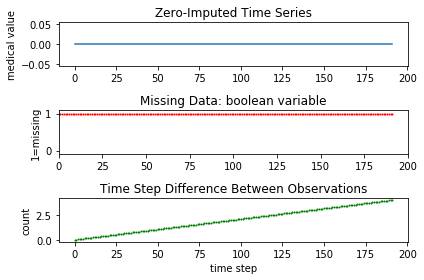

(192,)
Patient number 0 Medical variable  47


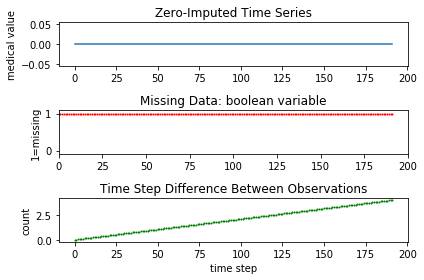

(192,)
Patient number 0 Medical variable  48


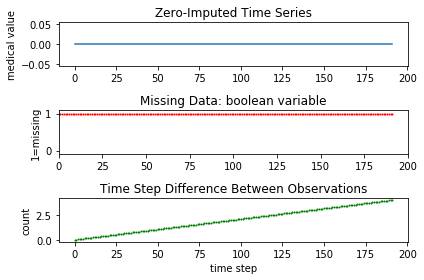

(192,)
Patient number 0 Medical variable  49


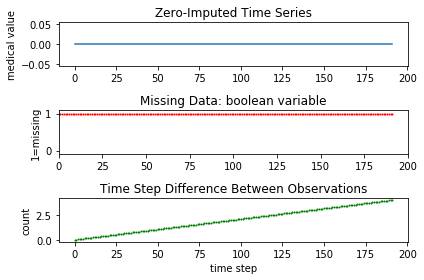

(192,)
Patient number 0 Medical variable  50


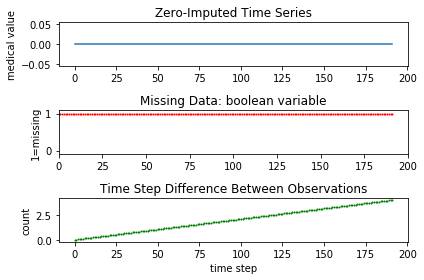

(192,)
Patient number 0 Medical variable  51


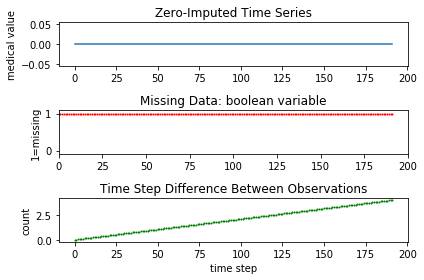

(192,)
Patient number 0 Medical variable  52


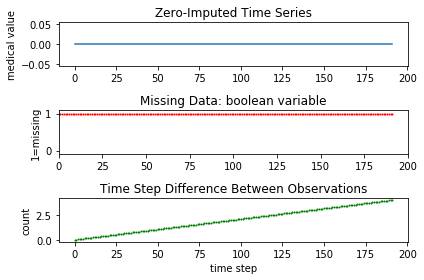

(192,)
Patient number 0 Medical variable  53


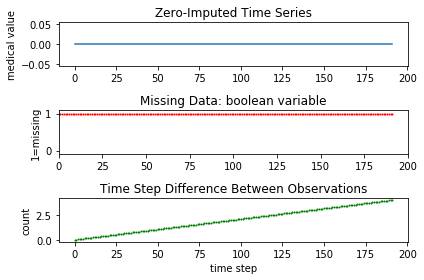

(192,)
Patient number 0 Medical variable  54


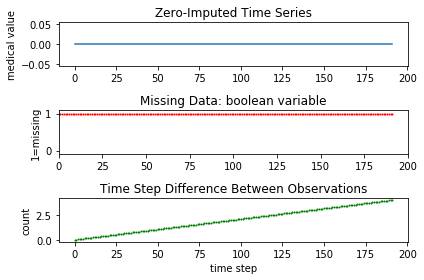

(192,)
Patient number 0 Medical variable  55


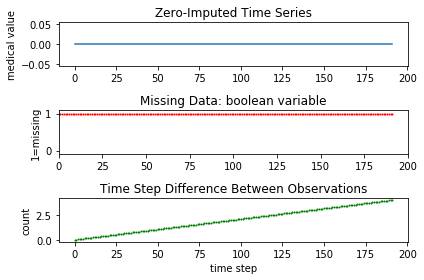

(192,)
Patient number 0 Medical variable  56


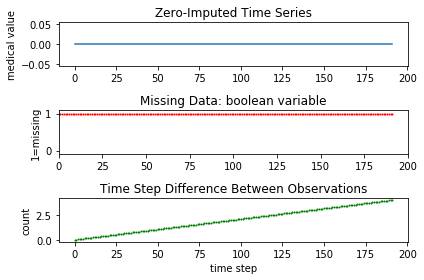

(192,)
Patient number 0 Medical variable  57


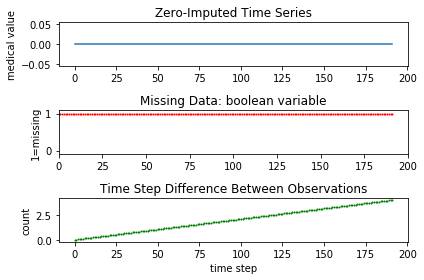

(192,)
Patient number 0 Medical variable  58


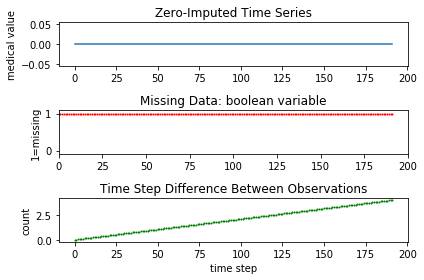

torch.Size([2, 192, 58])
(192,)
Patient number 1 Medical variable  0


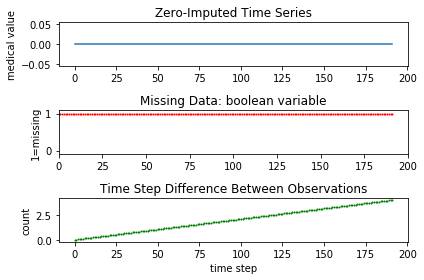

(192,)
Patient number 1 Medical variable  1


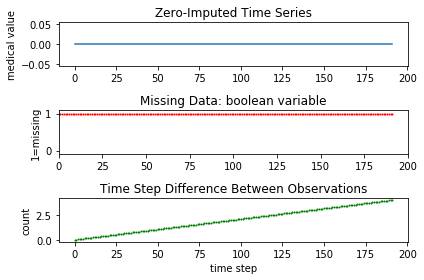

(192,)
Patient number 1 Medical variable  2


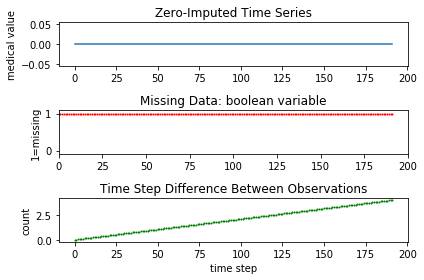

(192,)
Patient number 1 Medical variable  3


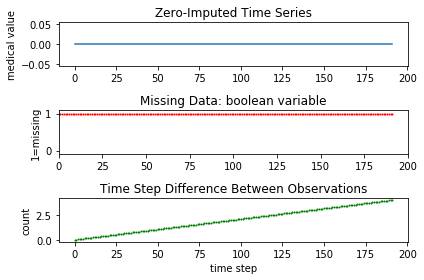

(192,)
Patient number 1 Medical variable  4


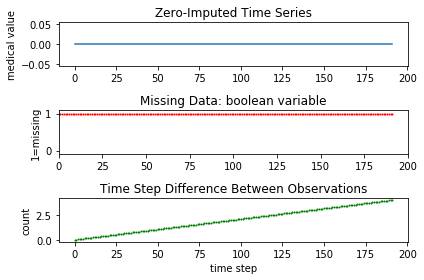

(192,)
Patient number 1 Medical variable  5


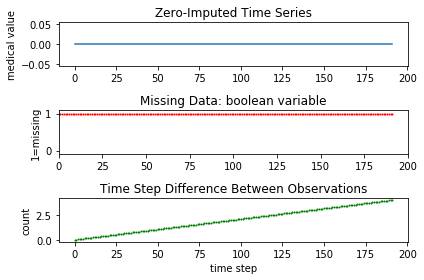

(192,)
Patient number 1 Medical variable  6


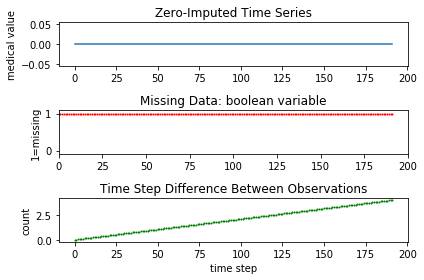

(192,)
Patient number 1 Medical variable  7


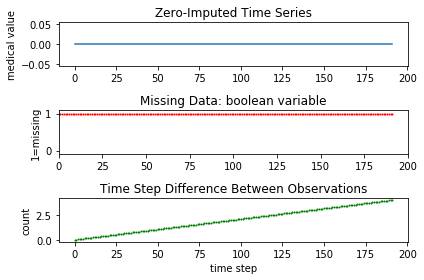

(192,)
Patient number 1 Medical variable  8


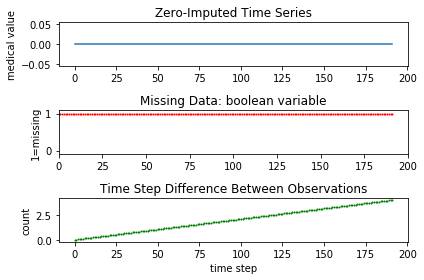

(192,)
Patient number 1 Medical variable  9


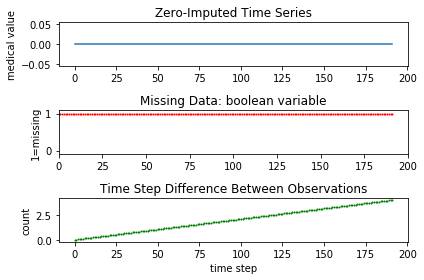

(192,)
Patient number 1 Medical variable  10


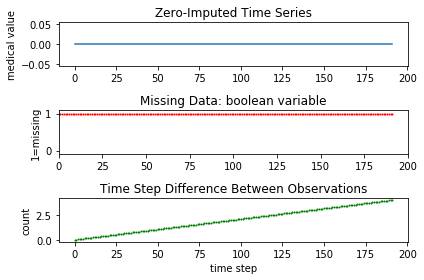

(192,)
Patient number 1 Medical variable  11


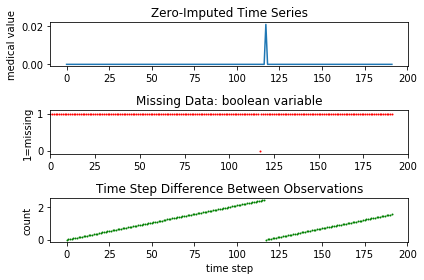

(192,)
Patient number 1 Medical variable  12


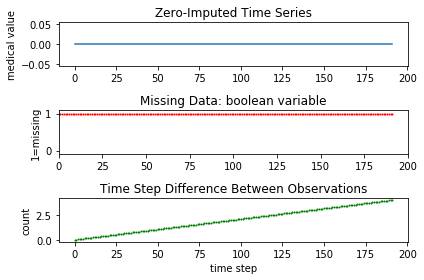

(192,)
Patient number 1 Medical variable  13


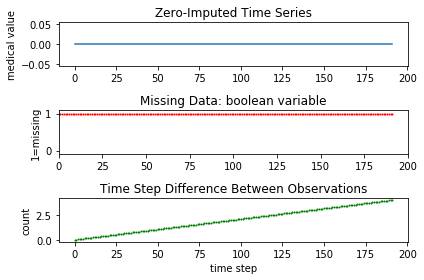

(192,)
Patient number 1 Medical variable  14


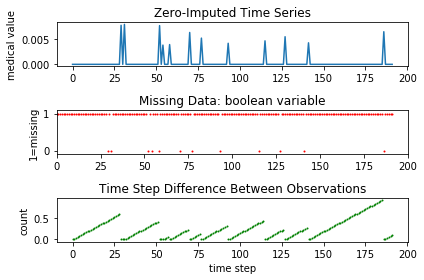

(192,)
Patient number 1 Medical variable  15


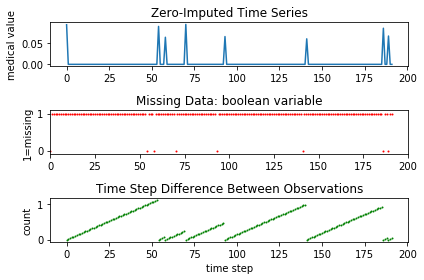

(192,)
Patient number 1 Medical variable  16


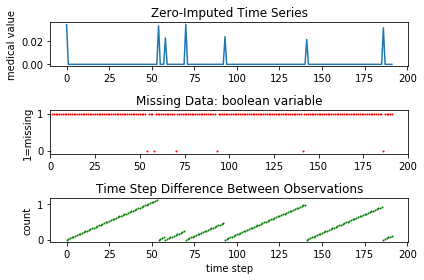

(192,)
Patient number 1 Medical variable  17


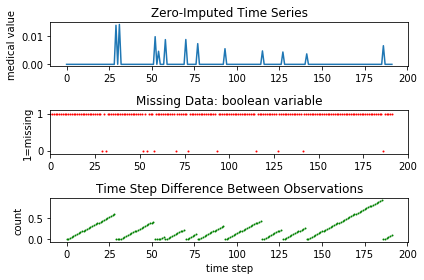

(192,)
Patient number 1 Medical variable  18


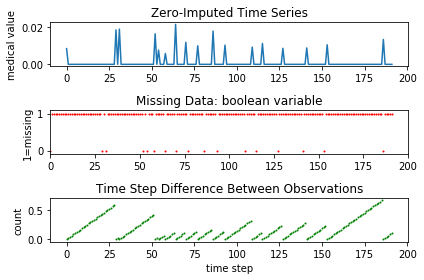

(192,)
Patient number 1 Medical variable  19


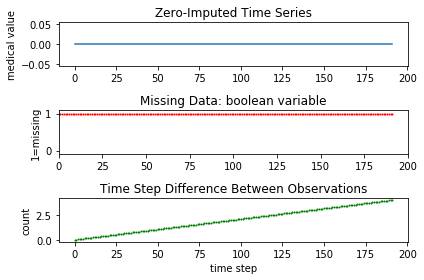

(192,)
Patient number 1 Medical variable  20


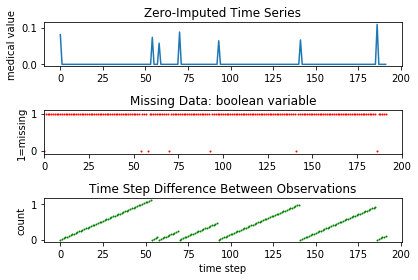

(192,)
Patient number 1 Medical variable  21


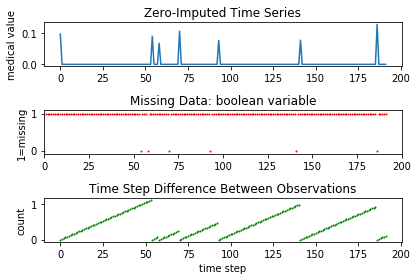

(192,)
Patient number 1 Medical variable  22


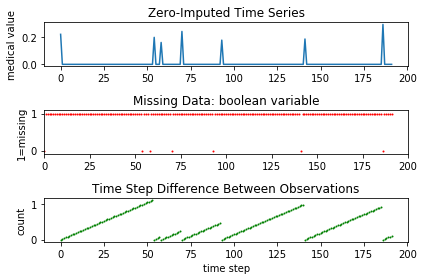

(192,)
Patient number 1 Medical variable  23


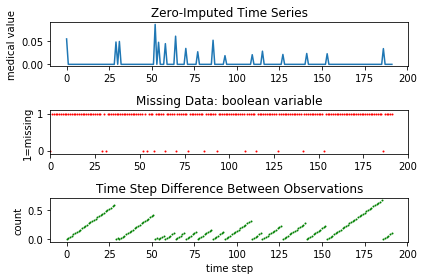

(192,)
Patient number 1 Medical variable  24


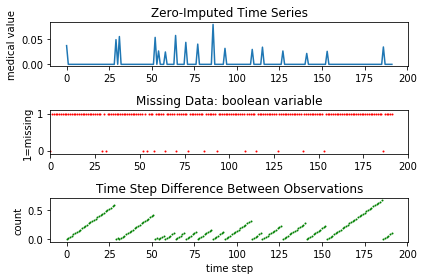

(192,)
Patient number 1 Medical variable  25


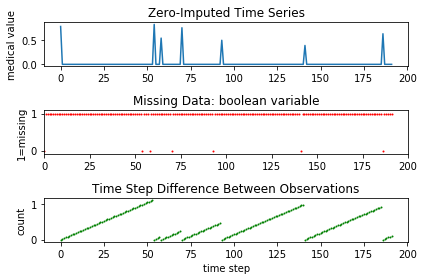

(192,)
Patient number 1 Medical variable  26


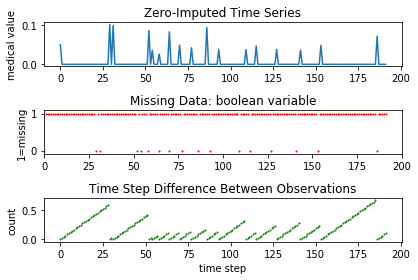

(192,)
Patient number 1 Medical variable  27


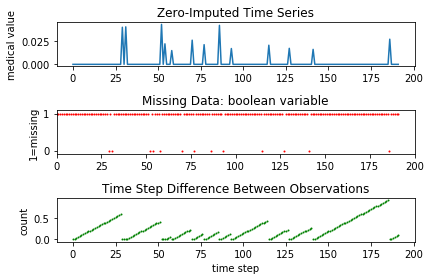

(192,)
Patient number 1 Medical variable  28


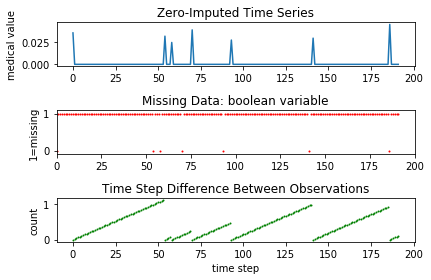

(192,)
Patient number 1 Medical variable  29


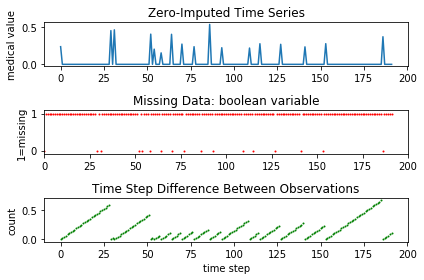

(192,)
Patient number 1 Medical variable  30


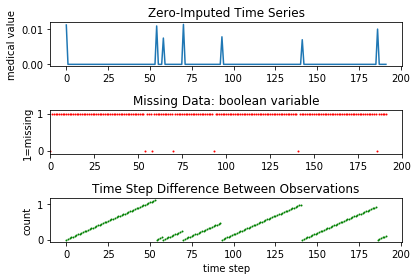

(192,)
Patient number 1 Medical variable  31


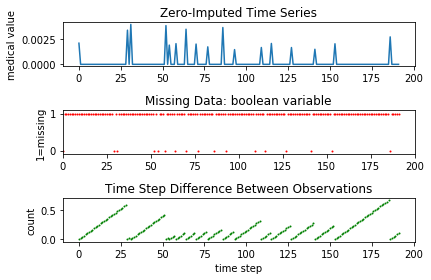

(192,)
Patient number 1 Medical variable  32


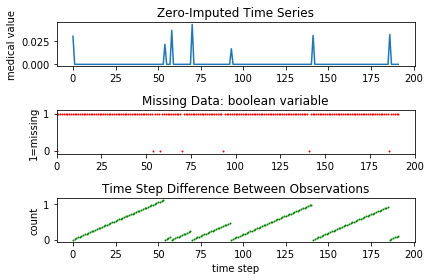

(192,)
Patient number 1 Medical variable  33


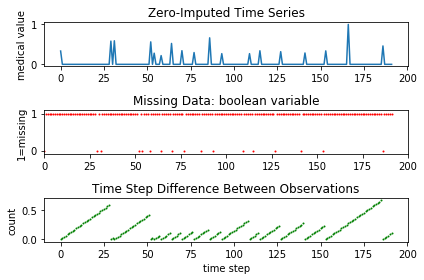

(192,)
Patient number 1 Medical variable  34


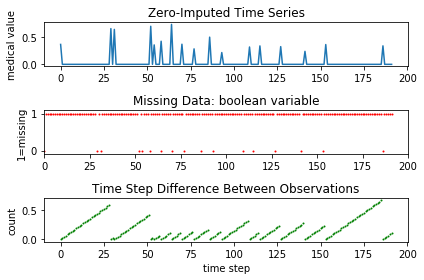

(192,)
Patient number 1 Medical variable  35


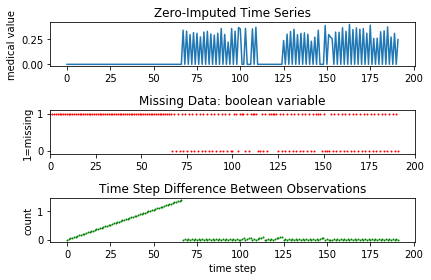

(192,)
Patient number 1 Medical variable  36


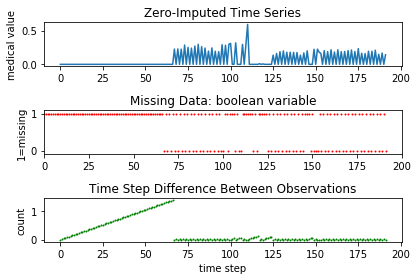

(192,)
Patient number 1 Medical variable  37


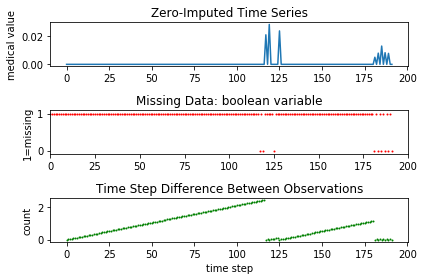

(192,)
Patient number 1 Medical variable  38


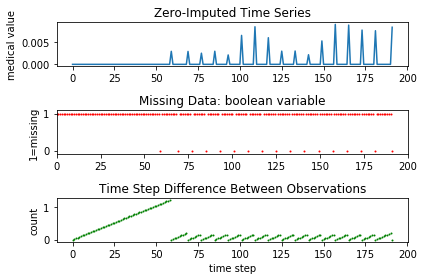

(192,)
Patient number 1 Medical variable  39


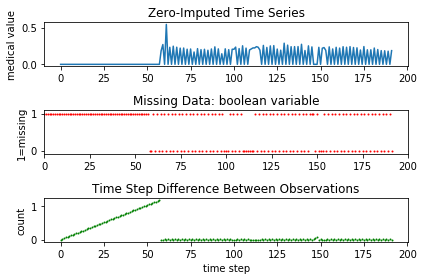

(192,)
Patient number 1 Medical variable  40


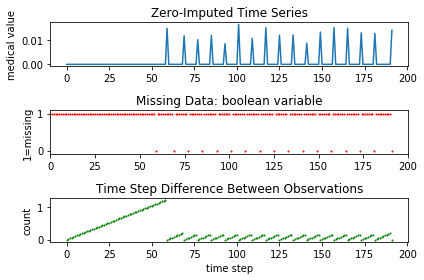

(192,)
Patient number 1 Medical variable  41


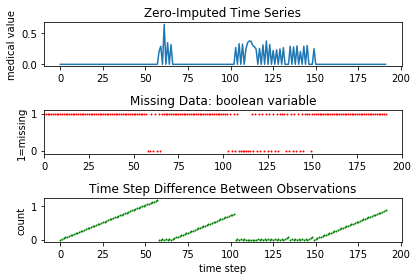

(192,)
Patient number 1 Medical variable  42


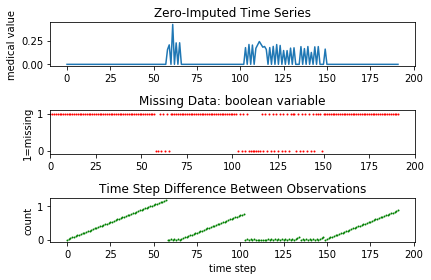

(192,)
Patient number 1 Medical variable  43


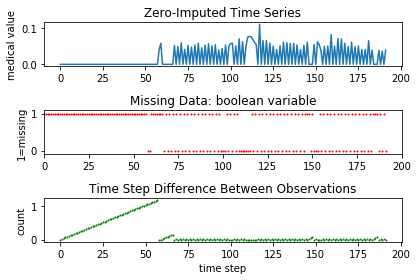

(192,)
Patient number 1 Medical variable  44


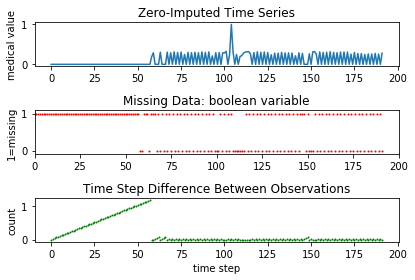

(192,)
Patient number 1 Medical variable  45


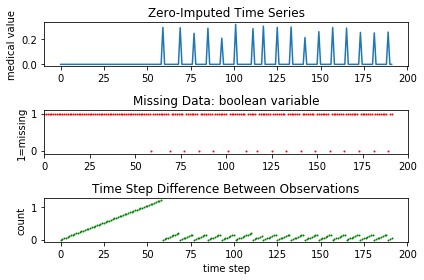

(192,)
Patient number 1 Medical variable  46


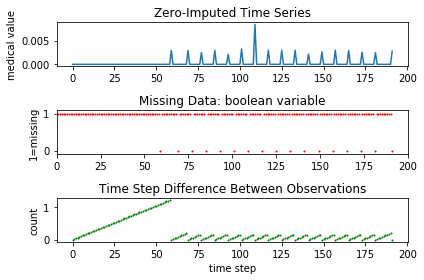

(192,)
Patient number 1 Medical variable  47


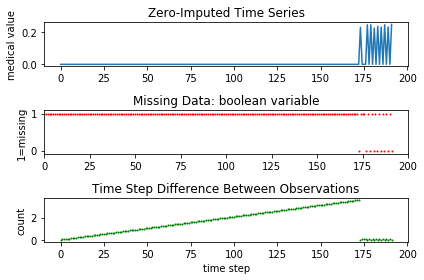

(192,)
Patient number 1 Medical variable  48


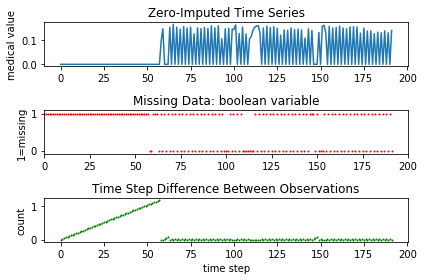

(192,)
Patient number 1 Medical variable  49


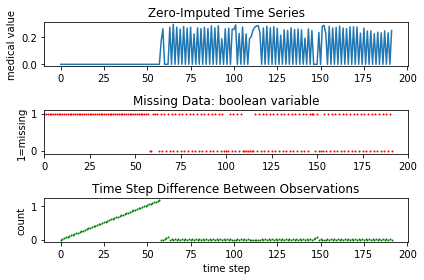

(192,)
Patient number 1 Medical variable  50


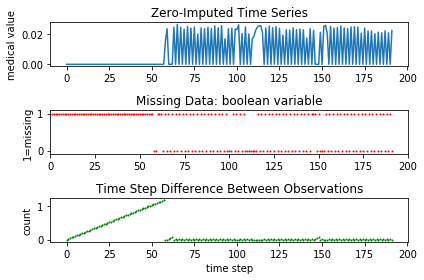

(192,)
Patient number 1 Medical variable  51


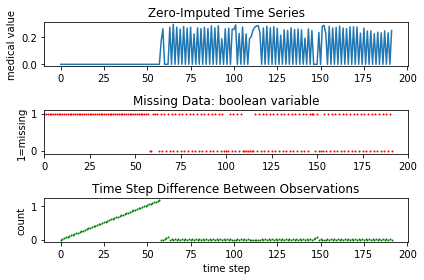

(192,)
Patient number 1 Medical variable  52


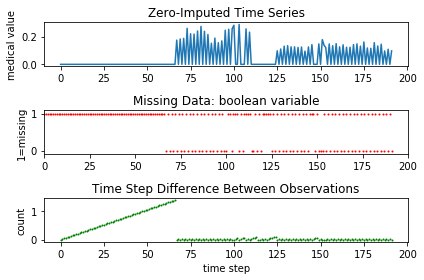

(192,)
Patient number 1 Medical variable  53


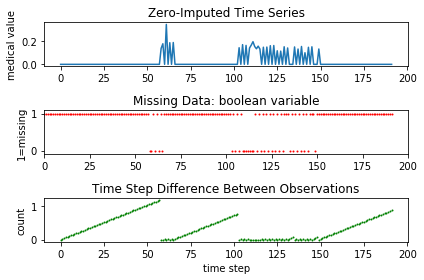

(192,)
Patient number 1 Medical variable  54


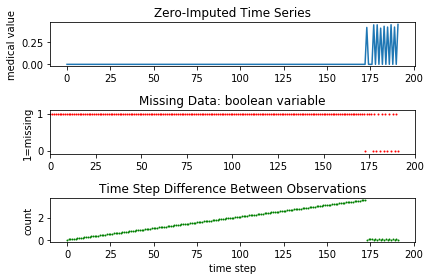

(192,)
Patient number 1 Medical variable  55


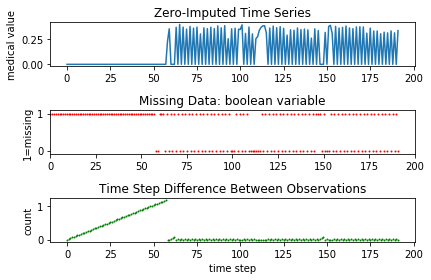

(192,)
Patient number 1 Medical variable  56


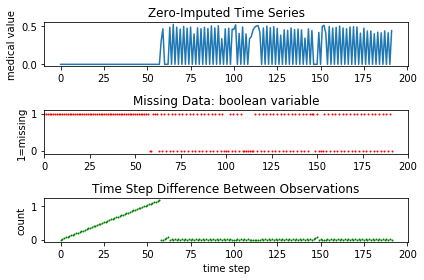

(192,)
Patient number 1 Medical variable  57


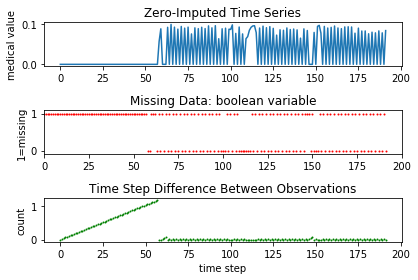

(192,)
Patient number 1 Medical variable  58


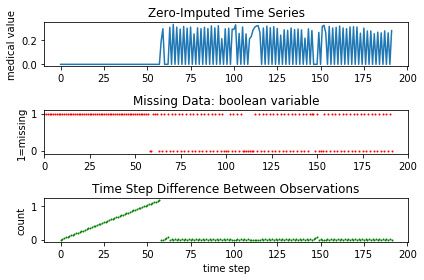

torch.Size([2, 192, 58])
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.4145, 0.0777, 0.2591],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4440, 0.0833, 0.2775]]]), tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  .

In [12]:

# INPUT NUMBER OF PATIENTS, TIMESERIES TENSOR, MASKS TENSOR AND DIFFS

def tensorLOCF(timeSeries, masks, diffs):
    
    sizeArr = list(timeSeries.size())
    # numPatients = sizeArr[0]
    numTimeSteps = sizeArr[1]
    numVariables = sizeArr[2]
    
    numPatients = 2
    
    print(numPatients)
    timeSeriesTensor = torch.zeros(size=(numPatients, numTimeSteps, numVariables-1))
    maskTensor = torch.zeros(size=(numPatients, numTimeSteps, numVariables-1))
    diffTensor = torch.zeros(size=(numPatients, numTimeSteps, numVariables-1))
    
    for i in range(numPatients):
        numpyTimeSeries = timeSeries.numpy()
        numpyMasks = masks.numpy()
        numpyDiffs = diffs.numpy()
        
        timeStepVector = [x for x in range(192)]
        
        patientTS, patientMask, patientDiff = simpleLOCF(numpyTimeSeries[i], numpyMasks[i], numpyDiffs[i])
        
        for j in range(numVariables): # 59
            
            if(j==19):
                
                pass
            
            oneTimeSeries = np.asarray(numpyTimeSeries[i, :, j]) # for patient i and variable j, take the column
            print(np.shape(oneTimeSeries))
            oneMask = np.asarray(numpyMasks[i, ..., j])
            oneDiff = np.asarray(numpyDiffs[i, ..., j])
            
            print("Patient number", i, "Medical variable ", j)
            plt.subplot(3,1,1)
            plt.plot(timeStepVector, oneTimeSeries)
            plt.title('Zero-Imputed Time Series')
            plt.ylabel('medical value')
            plt.xlabel('')
            
            plt.subplot(3,1,2)
            plt.scatter(timeStepVector, oneMask, color="red", s=1)
            plt.title('Missing Data: boolean variable')
            plt.ylabel('1=missing')
            plt.axis([0, 200, -.092, 1.092])
            plt.xlabel('')
            
            plt.subplot(3,1,3)
            plt.scatter(timeStepVector, oneDiff, c='green', s=1)
            plt.title('Time Step Difference Between Observations')
            plt.ylabel('count')
            plt.xlabel('time step')
            plt.tight_layout()
            plt.show()
            
            # it's j-1 because there's 58 variables now, not 59
            if(j>19):
                
                timeSeriesTensor[i, ..., j-1] = (torch.from_numpy((oneTimeSeries))) # stores into one giant tensor, 6261 x 192 x 59
                maskTensor[i, ..., j-1] = (torch.from_numpy(np.asarray(oneMask)))
                diffTensor[i, ..., j-1] = (torch.from_numpy(np.asarray(oneDiff)))
        
        print(timeSeriesTensor.shape)
        
    return timeSeriesTensor, maskTensor, diffTensor

print(tensorLOCF(tensorTimeSeries, tensorMasks, tensorDiffs))


In [26]:
# experimenting with impyute library

import impyute as impy

n = 5
arr = np.random.uniform(high = 6, size =(n,n))
for _ in range(3):
    arr[np.random.randint(n), np.random.randint(n)] = np.nan

print(arr)
print()

print("After mean imputation: \n", impy.mean(arr))
print()

print("After last observation carried forward: \n", impy.locf(arr))


[[2.8858978  3.66531098        nan 1.18402006        nan]
 [1.1830483  0.90462498 4.34034573 5.56649221 5.26549588]
 [1.91102636 0.53634275 1.71320652 3.25279746 0.0888119 ]
 [1.81530238        nan 0.69119941 2.36942691 4.80452743]
 [1.84079328 4.44055784 2.10844067 1.99539683 4.59557605]]

After mean imputation: 
 [[2.8858978  3.66531098 2.21329808 1.18402006 3.68860281]
 [1.1830483  0.90462498 4.34034573 5.56649221 5.26549588]
 [1.91102636 0.53634275 1.71320652 3.25279746 0.0888119 ]
 [1.81530238 2.38670914 0.69119941 2.36942691 4.80452743]
 [1.84079328 4.44055784 2.10844067 1.99539683 4.59557605]]

After last observation carried forward: 
 [[2.8858978  1.1830483  1.91102636 1.81530238 1.84079328]
 [3.66531098 0.90462498 0.53634275 1.81530238 4.44055784]
 [3.66531098 4.34034573 1.71320652 0.69119941 2.10844067]
 [1.18402006 5.56649221 3.25279746 2.36942691 1.99539683]
 [1.18402006 5.26549588 0.0888119  4.80452743 4.59557605]]
